In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kuliah/TKC/Code"

In [3]:
#Gathering Data
import os
import cv2

base_dir = '/content/drive/MyDrive/Kuliah/TKC/Code/DatasetCombinedv2'

mask_dir = os.path.join(base_dir, 'WithMask')
wout_dir = os.path.join(base_dir, 'WithoutMask')
    
mask_img_dir = list()
wout_img_dir = list()

for dirpath, dirnames, filenames in os.walk(mask_dir):
    for file in filenames:
        if ".png" in file:
            image_path = os.path.join(dirpath, file)
            mask_img_dir.append(image_path)

for dirpath, dirnames, filenames in os.walk(wout_dir):
    for file in filenames:
        if ".png" in file:
            image_path = os.path.join(dirpath, file)
            wout_img_dir.append(image_path)

In [4]:
#Resize + Save
from random import shuffle

target_dir = '/content/drive/MyDrive/Kuliah/TKC/Code/DatasetCombinedResized'

#shuffle(mask_dir)
#shuffle(wout_dir)
    
for i, img_path in enumerate(mask_img_dir[:200]):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (300,300))

    file_name = f"mask-{i + 1}.png"
    dest = os.path.join(target_dir, file_name)
    
    cv2.imwrite(dest, image)

for i, img_path in enumerate(wout_img_dir[:200]):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (300,300))

    file_name = f"wout-{i + 1}.png"
    dest = os.path.join(target_dir, file_name)
    
    cv2.imwrite(dest, image)

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from pathlib import Path
from PIL import Image
import numpy as np

In [12]:
base_model = VGG16 () #build modelnya
model = Model(inputs=base_model.input,
                   outputs=base_model.get_layer('predictions').output)

model.save('/content/drive/MyDrive/Kuliah/TKC/Code/maskDetect_model.h5')

In [13]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
    
    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        	
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        
        return feature / np.linalg.norm(feature)

fe = FeatureExtractor(load_model('/content/drive/MyDrive/Kuliah/TKC/Code/maskDetect_model.h5', compile=False))

In [15]:
base_dir = '/content/drive/MyDrive/Kuliah/TKC/Code/DatasetCombinedResized'
feature_dir = '/content/drive/MyDrive/Kuliah/TKC/Code/feature_extract'

img_paths = list()
features = list()

for img_path in sorted(Path(base_dir).glob("*.png")):
    img_paths.append(img_path)
    feature = fe.extract(img=Image.open(img_path))
    features.append(feature)

features = np.array(features)
np.save(feature_dir + '/extracted_feature_v1.npy', features)

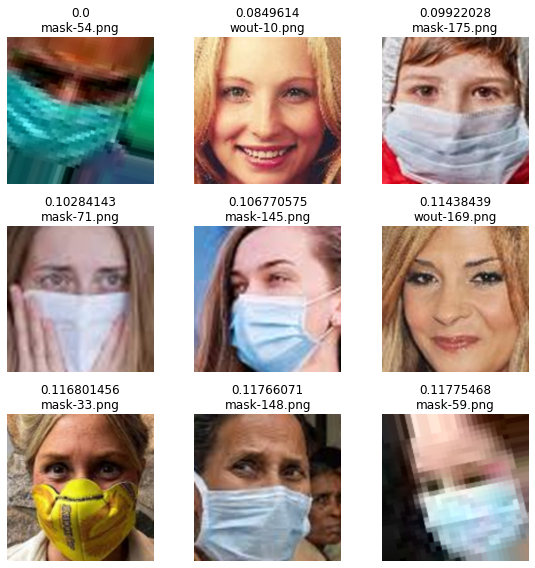

In [16]:
#Testing Image
import matplotlib.pyplot as plt
import numpy as np
import os

query_image = img_paths[150]
img = Image.open(query_image)

query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

# Extract 9 images that have lowest distance
ids = np.argsort(dists)[:9]
scores = [(dists[id], img_paths[id]) for id in ids]

# Visualize the result
axes = list()
fig = plt.figure(figsize=(8,8))

for a in range(3 * 3):
    axes.append(fig.add_subplot(3, 3, a+1))

    score = scores[a]

    nama_citra = os.path.basename(score[1])

    subplot_title = str(score[0]) + f"\n{nama_citra}"
    axes[-1].set_title(subplot_title)  

    plt.axis('off')
    plt.imshow(Image.open(score[1]))

fig.tight_layout()
plt.show()

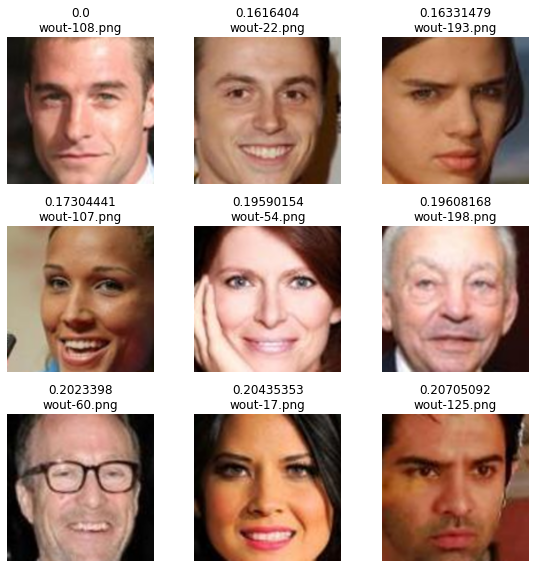

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os

query_image = img_paths[210]
img = Image.open(query_image)

query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

# Extract 9 images that have lowest distance
ids = np.argsort(dists)[:9]
scores = [(dists[id], img_paths[id]) for id in ids]

# Visualize the result
axes = list()
fig = plt.figure(figsize=(8,8))

for a in range(3 * 3):
    axes.append(fig.add_subplot(3, 3, a+1))

    score = scores[a]

    nama_citra = os.path.basename(score[1])

    subplot_title = str(score[0]) + f"\n{nama_citra}"
    axes[-1].set_title(subplot_title)  

    plt.axis('off')
    plt.imshow(Image.open(score[1]))

fig.tight_layout()
plt.show()